In [2]:
print('hello world Jupyter')


hello world Jupyter


# Import Required Libraries
Import libraries such as NumPy, pandas, and matplotlib for numerical computations, data handling, and visualization.

In [3]:
# Import necessary libraries for numerical computations, data handling, and visualization
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Define Interest Rate Swap Parameters
Define parameters for the interest rate swap, including notional amount, fixed rate, floating rate index, and maturity.

In [4]:
# Define parameters for the interest rate swap
notional_amount = 1000000  # Notional amount in USD
fixed_rate = 0.02  # Fixed rate (2%)
floating_rate_index = "LIBOR"  # Floating rate index
maturity_years = 5  # Maturity in years

# Display the defined parameters
print("Interest Rate Swap Parameters:")
print(f"Notional Amount: ${notional_amount}")
print(f"Fixed Rate: {fixed_rate * 100}%")
print(f"Floating Rate Index: {floating_rate_index}")
print(f"Maturity: {maturity_years} years")

Interest Rate Swap Parameters:
Notional Amount: $1000000
Fixed Rate: 2.0%
Floating Rate Index: LIBOR
Maturity: 5 years


# Simulate Interest Rate Paths
Use a stochastic model (e.g., Hull-White or Black-Karasinski) to simulate interest rate paths over time.

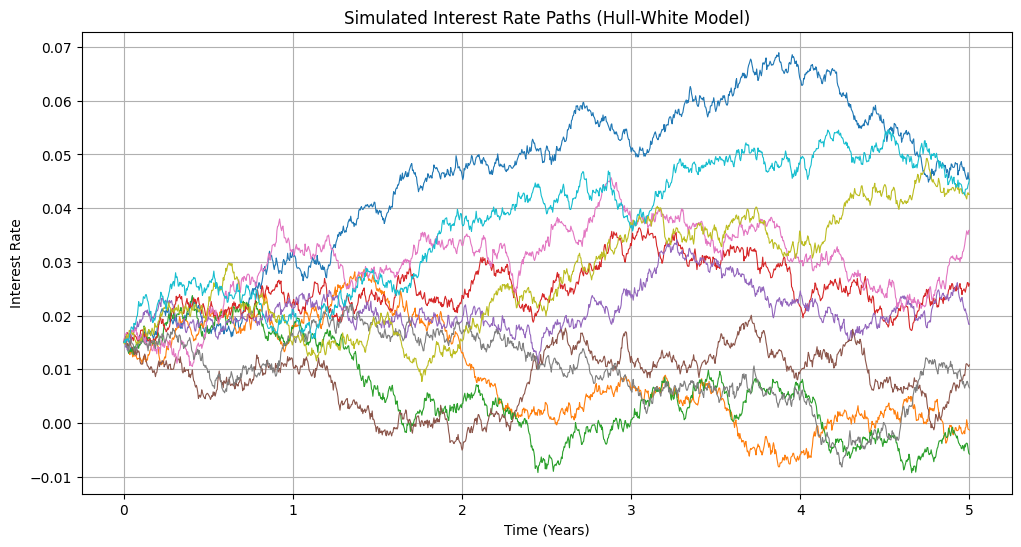

In [5]:
# Define parameters for the Hull-White model
mean_reversion_speed = 0.03  # Speed of mean reversion (kappa)
long_term_mean_rate = 0.02  # Long-term mean rate (theta)
volatility = 0.01  # Volatility of interest rates (sigma)
time_steps = 252  # Number of time steps in a year
total_years = maturity_years  # Total simulation years
dt = 1 / time_steps  # Time step size

# Initialize arrays to store simulated interest rate paths
num_simulations = 1000  # Number of Monte Carlo simulations
interest_rate_paths = np.zeros((num_simulations, total_years * time_steps + 1))

# Set initial interest rate (e.g., current LIBOR rate)
initial_rate = 0.015  # 1.5%
interest_rate_paths[:, 0] = initial_rate

# Simulate interest rate paths using the Hull-White model
np.random.seed(42)  # Set seed for reproducibility
for t in range(1, total_years * time_steps + 1):
    # Generate random normal shocks
    z = np.random.normal(0, 1, num_simulations)
    # Apply the Hull-White model formula
    dr = mean_reversion_speed * (long_term_mean_rate - interest_rate_paths[:, t - 1]) * dt + \
         volatility * np.sqrt(dt) * z
    interest_rate_paths[:, t] = interest_rate_paths[:, t - 1] + dr

# Plot a subset of simulated interest rate paths
plt.figure(figsize=(12, 6))
for i in range(10):  # Plot 10 random paths
    plt.plot(np.linspace(0, total_years, total_years * time_steps + 1), interest_rate_paths[i, :], lw=0.8)
plt.title("Simulated Interest Rate Paths (Hull-White Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()

# Calculate Exposure Profiles
Compute the potential future exposure (PFE) and expected exposure (EE) for the interest rate swap based on the simulated paths.

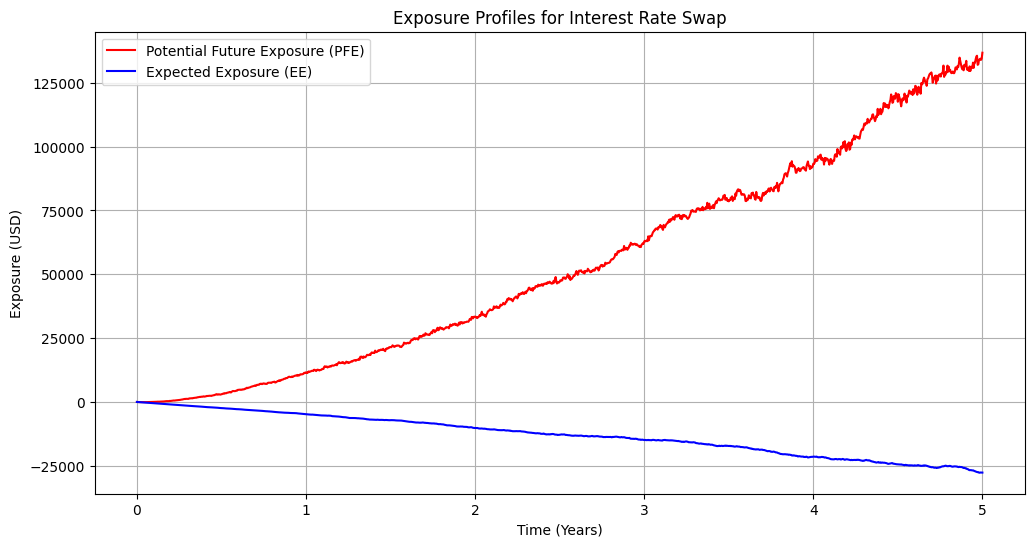

In [6]:
# Calculate Exposure Profiles

# Define a function to calculate the discounted cash flows for the interest rate swap
def calculate_swap_exposure(interest_rate_paths, notional_amount, fixed_rate, dt):
    num_simulations, num_steps = interest_rate_paths.shape
    discounted_cash_flows = np.zeros((num_simulations, num_steps))
    
    for t in range(1, num_steps):
        # Calculate the floating rate cash flow
        floating_rate_cash_flow = interest_rate_paths[:, t] * notional_amount * dt
        # Calculate the fixed rate cash flow
        fixed_rate_cash_flow = fixed_rate * notional_amount * dt
        # Net cash flow (floating - fixed)
        net_cash_flow = floating_rate_cash_flow - fixed_rate_cash_flow
        # Discount the net cash flow to the present value
        discount_factor = np.exp(-np.cumsum(interest_rate_paths[:, :t], axis=1) * dt)
        discounted_cash_flows[:, t] = np.sum(net_cash_flow[:, None] * discount_factor, axis=1)
    
    return discounted_cash_flows

# Calculate the discounted cash flows for the interest rate swap
discounted_cash_flows = calculate_swap_exposure(interest_rate_paths, notional_amount, fixed_rate, dt)

# Compute the Potential Future Exposure (PFE) and Expected Exposure (EE)
pfe = np.percentile(discounted_cash_flows, 95, axis=0)  # 95th percentile
ee = np.mean(discounted_cash_flows, axis=0)  # Average exposure

# Plot the PFE and EE profiles
plt.figure(figsize=(12, 6))
time_grid = np.linspace(0, total_years, total_years * time_steps + 1)
plt.plot(time_grid, pfe, label="Potential Future Exposure (PFE)", color="red")
plt.plot(time_grid, ee, label="Expected Exposure (EE)", color="blue")
plt.title("Exposure Profiles for Interest Rate Swap")
plt.xlabel("Time (Years)")
plt.ylabel("Exposure (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Compute xVA Metrics
Calculate xVA metrics such as CVA (Credit Valuation Adjustment), DVA (Debit Valuation Adjustment), and FVA (Funding Valuation Adjustment).

In [7]:
# Compute xVA Metrics

# Define a function to calculate CVA (Credit Valuation Adjustment)
def calculate_cva(ee, counterparty_pd, counterparty_lgd, dt):
    """
    CVA is calculated as the discounted sum of expected exposure (EE) 
    multiplied by the counterparty's probability of default (PD) and loss given default (LGD).
    """
    cva = np.sum(ee * counterparty_pd * counterparty_lgd * dt)
    return cva

# Define a function to calculate DVA (Debit Valuation Adjustment)
def calculate_dva(ee, own_pd, own_lgd, dt):
    """
    DVA is calculated as the discounted sum of expected exposure (EE) 
    multiplied by the firm's own probability of default (PD) and loss given default (LGD).
    """
    dva = np.sum(ee * own_pd * own_lgd * dt)
    return dva

# Define a function to calculate FVA (Funding Valuation Adjustment)
def calculate_fva(ee, funding_spread, dt):
    """
    FVA is calculated as the discounted sum of expected exposure (EE) 
    multiplied by the funding spread.
    """
    fva = np.sum(ee * funding_spread * dt)
    return fva

# Define parameters for xVA calculations
counterparty_pd = 0.01  # Counterparty probability of default per year
counterparty_lgd = 0.6  # Counterparty loss given default (60%)
own_pd = 0.005  # Firm's own probability of default per year
own_lgd = 0.4  # Firm's own loss given default (40%)
funding_spread = 0.002  # Funding spread (0.2%)

# Calculate CVA, DVA, and FVA
cva = calculate_cva(ee, counterparty_pd, counterparty_lgd, dt)
dva = calculate_dva(ee, own_pd, own_lgd, dt)
fva = calculate_fva(ee, funding_spread, dt)

# Display the calculated xVA metrics
print("xVA Metrics:")
print(f"Credit Valuation Adjustment (CVA): ${cva:,.2f}")
print(f"Debit Valuation Adjustment (DVA): ${dva:,.2f}")
print(f"Funding Valuation Adjustment (FVA): ${fva:,.2f}")

xVA Metrics:
Credit Valuation Adjustment (CVA): $-385.05
Debit Valuation Adjustment (DVA): $-128.35
Funding Valuation Adjustment (FVA): $-128.35
